In [ ]:
# INSTALL MODULES

%pip install pickle5

# IMPORTS
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import os
import pickle5 as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mount Google Drive in Colab
#from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

# Import modules in Colab from other notebooks
%run '/content/gdrive/MyDrive/Colab Notebooks/dataset.ipynb'
%run '/content/gdrive/MyDrive/Colab Notebooks/models.ipynb'

if not torch.cuda.is_available():
    raise RuntimeError("You should enable GPU runtime.")

     |████████████████████████████████| 133kB 17.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219276 sha256=8cf2822a8ac913cb5a57fc6417ecf4b30478a40226b4c7a198d485dfa97e8317
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
Mounted at /content/gdrive


In [ ]:
# To speed up training, it's better to copy dataset from Drive to a Colab folder

# choose a local (colab) directory to store the data.
local_dataset_path = os.path.expanduser('/content/data')
try:
  os.makedirs(local_dataset_path)
except: pass

dataset_path = '/content/gdrive/MyDrive/jester_dataset'

!cp -avr "{dataset_path}" "{local_dataset_path}"

# Make sure it's there
!ls -lha /content/gdrive/MyDrive/jester_dataset/features

'/content/gdrive/MyDrive/jester_dataset' -> '/content/data/jester_dataset'
'/content/gdrive/MyDrive/jester_dataset/features' -> '/content/data/jester_dataset/features'
'/content/gdrive/MyDrive/jester_dataset/features/features_flow.pickle' -> '/content/data/jester_dataset/features/features_flow.pickle'
'/content/gdrive/MyDrive/jester_dataset/features/features_RGB.pickle' -> '/content/data/jester_dataset/features/features_RGB.pickle'
'/content/gdrive/MyDrive/jester_dataset/csv' -> '/content/data/jester_dataset/csv'
'/content/gdrive/MyDrive/jester_dataset/csv/validation.csv' -> '/content/data/jester_dataset/csv/validation.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/train.csv' -> '/content/data/jester_dataset/csv/train.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/labels.csv' -> '/content/data/jester_dataset/csv/labels.csv'
'/content/gdrive/MyDrive/jester_dataset/csv/train.gsheet' -> '/content/data/jester_dataset/csv/train.gsheet'
cp: cannot open '/content/gdrive/MyDrive/jester_dat

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Retrieves features from i3d_resnet50_v1_kinetics400 Gluon pre-trained model extracted from our 9 classes' Jester dataset videos
with open('/content/data/jester_dataset/features/features_RGB.pickle', 'rb') as handle:
    rgb_dict = pickle.load(handle)        # dict as {n_video:features, ...}  features: (1,2048)
with open('/content/data/jester_dataset/features/features_flow.pickle', 'rb') as handle:
    flow_dict = pickle.load(handle)        # dict as {n_video:features, ...}  features: (1,2048)
    
csv_dir = '/content/data/jester_dataset/csv/'  # if in Google Cloud --> csv_dir = '/mnt/disks/disk-1/jester_dataset/dataset/csvs/' 
train_csv = csv_dir + 'train.csv' 
val_csv = csv_dir + 'validation.csv'
labels = csv_dir + 'labels.csv'

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, epoch):  
  model.train()
  accs, losses = [], []
  train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
  for rgb, flow, labels in train_loop:
    train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, config["epochs"]))
    optimizer.zero_grad()
    rgb, flow, labels = rgb.to(device), flow.to(device), labels.to(device)
    output = model(rgb, flow)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    accs.append(accuracy(labels, output))
    losses.append(loss.item())
    train_loop.set_postfix(loss=np.mean(losses), accuracy=np.mean(accs))
  return np.mean(losses), np.mean(accs)

In [ ]:
def eval_epoch(model, val_loader, criterion, epoch): 
  with torch.no_grad():
    model.eval()
    accs, losses = [], []
    val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
    for rgb, flow, labels in val_loop:
      val_loop.set_description('[  VAL] Epoch {}/{}'.format(epoch + 1, config["epochs"]))
      rgb, flow, labels = rgb.to(device), flow.to(device), labels.to(device)
      output = model(rgb, flow)
      loss = criterion(output, labels)
      accs.append(accuracy(labels, output))
      losses.append(loss.item())
      val_loop.set_postfix(loss=np.mean(losses), accuracy=np.mean(accs))
    return np.mean(losses), np.mean(accs)

In [ ]:
def accuracy(labels, outputs):
    preds = outputs.argmax(-1)
    acc = (preds == labels.view_as(preds)).cpu().float().detach().numpy().mean()
    return acc

In [ ]:
def train_model(config):
  # DATASETS
  train_dataset = JesterDatasetTwoStream(rgb_dict, flow_dict, train_csv, labels)
  validation_dataset = JesterDatasetTwoStream(rgb_dict, flow_dict, val_csv, labels)

  train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
  validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False)

  # MODEL
  model = ClassifierTwoStreamAfter(h_rgb=config['hidden_rgb'], h_flow=config['hidden_flow'], dropout=config['dropout']).to(device)
  optimizer = optim.Adam(model.parameters(), lr = config['lr'])
  #optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

  counts = pd.read_csv(train_csv).Action.value_counts()       # Counts = list of video counts for each class
  weights = torch.tensor([max(counts)/x for x in counts])     # calculates weights for all classes in training dataset (weight regularization)
  criterion = nn.CrossEntropyLoss(weight=weights).to(device)  # assigns weight to each of the classes. This is particularly useful when you have an unbalanced training set
  
  train_losses, val_losses, train_accs, val_accs = [], [], [], []

  for epoch in range(config['epochs']):
    
    loss, acc = train_epoch(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
        
    loss, acc = eval_epoch(model, validation_loader, criterion, epoch)
    val_losses.append(loss)
    val_accs.append(acc)
    
  # Saves the model_state_dict to load it later in the final system's model to do inference 
  savedir = '/content/gdrive/MyDrive/model/state_dict.pt'
  print(f"Saving checkpoint to {savedir}...")
  checkpoint = {
      "model_state_dict": model.cpu().state_dict(),
  }
  torch.save(checkpoint, savedir)
  
  return model, [train_losses, train_accs, val_losses, val_accs]

In [ ]:
if __name__ == "__main__":

    config = {
            "lr": 0.000178044,
            "batch_size": 64,
            "hidden_rgb": 1024,
            "hidden_flow": 1024,
            "dropout": 0.75,
            "epochs": 100,
    }

    trained_model, metrics = train_model(config)

    print("Training finished")
    
    

[  VAL] Epoch 100/100: 100%|██████████| 86/86 [00:03<00:00, 24.26 batches/s, accuracy=0.825, loss=0.551]


Saving checkpoint to /content/gdrive/MyDrive/model/state_dict.pt...
Training finished


Text(0, 0.5, 'Accuracy')

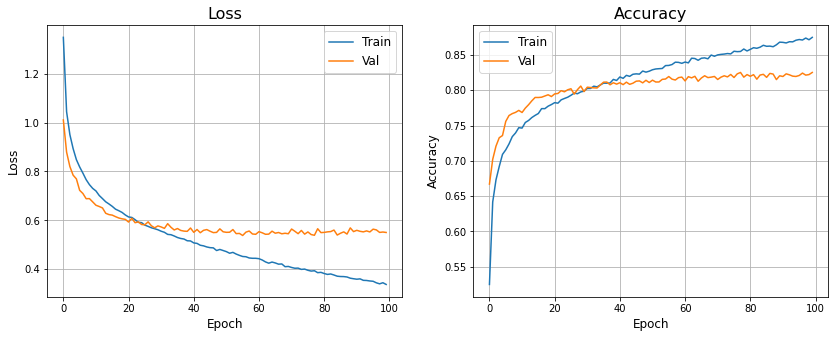

In [ ]:
fig = plt.figure(figsize=[14,5])
plt.subplot(1, 2, 1)
plt.plot(metrics[0],label='Train')
plt.plot(metrics[2],label='Val')
plt.legend(fontsize=12)
plt.title('Loss',fontsize=16)
plt.grid()
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(metrics[1],label='Train')
plt.plot(metrics[3],label='Val')
plt.title('Accuracy',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

Text(0.5, 42.0, 'Predicted label')

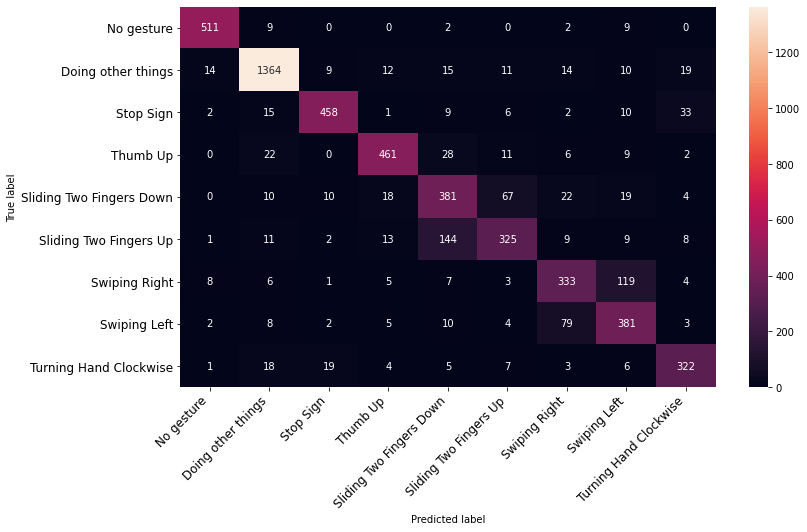

In [ ]:
import seaborn as sns
validation_dataset = JesterDataset(rgb_dict, flow_dict, val_csv, labels)

 
validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False)
nb_classes = 9
confusion_matrix = np.zeros((nb_classes, nb_classes))
trained_model = trained_model.to(device)
with torch.no_grad():
    for i, (rgb, flow, classes) in enumerate(validation_loader):
        rgb = rgb.to(device)
        flow = flow.to(device)
        classes = classes.to(device)
        outputs = trained_model(rgb, flow)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(12,7))

l = pd.read_csv(labels)
class_names = list(l['Actions'])
l['Accuracy'] = np.diag(confusion_matrix)/confusion_matrix.sum(1)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
l

,Actions,Accuracy
0,No gesture,0.958724
1,Doing other things,0.929155
2,Stop Sign,0.854478
3,Thumb Up,0.855288
4,Sliding Two Fingers Down,0.717514
5,Sliding Two Fingers Up,0.622605
6,Swiping Right,0.685185
7,Swiping Left,0.771255
8,Turning Hand Clockwise,0.836364
